# Postprocessing a DeepONet Trained for a Perfectlt Stirred Reactor

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from tensorflow                           import keras

import romnet                             as rmnt

In [2]:
### Input Data

ROMNetFldr    = WORKSPACE_PATH + '/ROMNet/romnet/'

OutputDir     = WORKSPACE_PATH+'/ROMNet/Data/PSR_10Cases/'
TestDir       = WORKSPACE_PATH+'/ROMNet/Data/PSR_10Cases_Test/'

PathToRunFld  = WORKSPACE_PATH + '/ROMNet/PSR_10Cases/DeepONet/Deterministic/Run_3/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/PSR_10Cases/DeepONet/MCDropOut/Run_2/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/PSR_10Cases/DeepONet/BayesByBackprop/Run_1/'

CasesVec      = [0] 
DirDir        = OutputDir #OutputDir #TestDir

NSamples      = 2

NVarsRed      = 3
TestInputVars = ['PC_'+str(i+1) for i in range(NVarsRed)]

In [3]:
print("\n[ROMNet]: Reading Input File from: ", PathToRunFld)
sys.path.insert(0, PathToRunFld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH, ROMNetFldr)


InputData.InputFilePath = PathToRunFld+'/ROMNet_Input.py'
InputData.TrainIntFlg   = 0
InputData.PathToRunFld  = PathToRunFld


[ROMNet]: Reading Input File from:  /Users/sventuri/WORKSPACE//ROMNet/PSR_10Cases/DeepONet/Deterministic/Run_3/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


In [4]:
SurrogateType = InputData.SurrogateType
if (SurrogateType == 'FNN-SourceTerms'):
    SurrogateType = 'FNN'

Net   = getattr(rmnt.nn, SurrogateType)

model = rmnt.model.Model_Deterministic(InputData)

model.build(InputData, None, Net)#, loadfile_no='000004')

NN    = model.net


[ROMNet]:   Initializing the ML Model

[ROMNet]:   Building the ML Model

[ROMNet]:   Loading ML Model Parameters from File:  /Users/sventuri/WORKSPACE//ROMNet/PSR_10Cases/DeepONet/Deterministic/Run_3//Training/Params//000728.h5
'load_params' took 0.055247 s


[ROMNet]:   Saving ML Model Parameters to File:  /Users/sventuri/WORKSPACE//ROMNet/PSR_10Cases/DeepONet/Deterministic/Run_3//Model/Params/Initial.h5
'save_params' took 0.054800 s

'build' took 0.680389 s



In [5]:
# LName   = 'Trunk_'+str(1)+'_HL' + str(len(InputData.TrunkActFun[0]))

# Trunk = keras.Model(NN.Model.inputs, NN.Model.get_layer(LName).output)
# Trunk.summary()

In [6]:
# LName   = 'Branch_'+InputData.BranchVars[0]+'_HL' + str(len(InputData.TrunkActFun[0]))
# '_HL' + str(len(InputData.BranchActFun[0]))

# Branch1 = keras.Model(NN.Model.inputs, NN.Model.get_layer(LName).output)
# Branch1.summary()

In [7]:
# LName   = 'Branch_'+InputData.BranchVars[1]+'_HL' + str(len(InputData.BranchActFun[1]))

# Branch2 = keras.Model(NN.Model.inputs, NN.Model.get_layer(LName).output)
# Branch2.summary()

In [8]:
FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

In [9]:
# ### Evaluating on Test Data

        
# FileName       = DirDir + '/Orig/train/ext/ResidenceTimes.csv'
# Data           = pd.read_csv(FileName, header=None)
# RestValVecTest = np.log10(Data.to_numpy())

# iPC = 3


# ax  = []

# fig = plt.figure(figsize=(16,12))
# ax.append(plt.axes())

# for iTest in CasesVec:
#     RestVal                      = RestValVecTest[iTest]

#     FileName                     = DirDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iTest+1)
#     InputDataTest                = pd.read_csv(FileName, header=0)
#     tVec                         = InputDataTest['t'].to_numpy()
#     InputDataTest['log10(t)']    = np.log10(tVec + 1.e-15)
#     InputDataTest['log10(Rest)'] = RestVal * np.ones(len(tVec))
#     yMatOrig_pca                 = InputDataTest[TestInputVars].to_numpy()
#     y0_pca                       = yMatOrig_pca[0,:]
#     print('RestVal = ', RestVal, '; y0_pca = ', y0_pca)

#     ax[0].plot(tVec, yMatOrig_pca[:,iPC], '-k',  label='Transformed Data', lw=2)

#     yMat_pca = model.predict(InputDataTest[['log10(Rest)','t']])
    
#     ax[0].plot(tVec, yMat_pca, ':r', label='DeepONet', lw=3)

# ax[0].set_xscale('log')
# ax[0].set_xlabel('time [s]')
# ax[0].set_ylabel(r'$PC_'+str(iPC+1)+'$')
# ax[0].legend()

iVar =  3
iVar =  2
RestVal =  [-5.] ; y0_pca =  [3.78659267e+02 2.13219893e-02 3.45811239e-03]


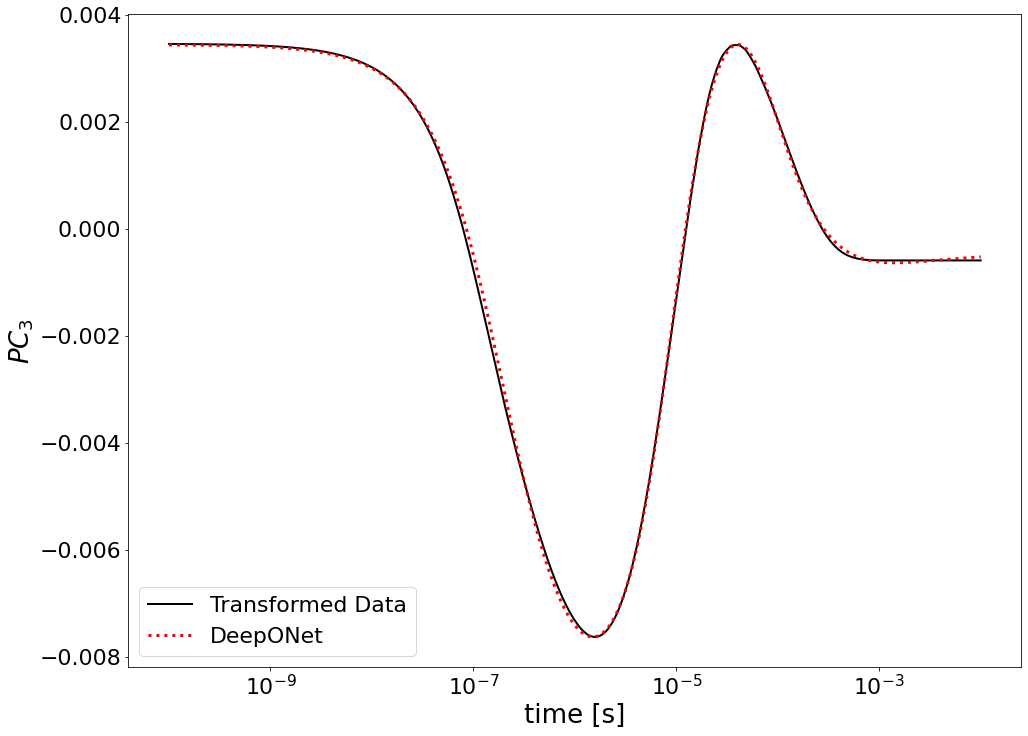

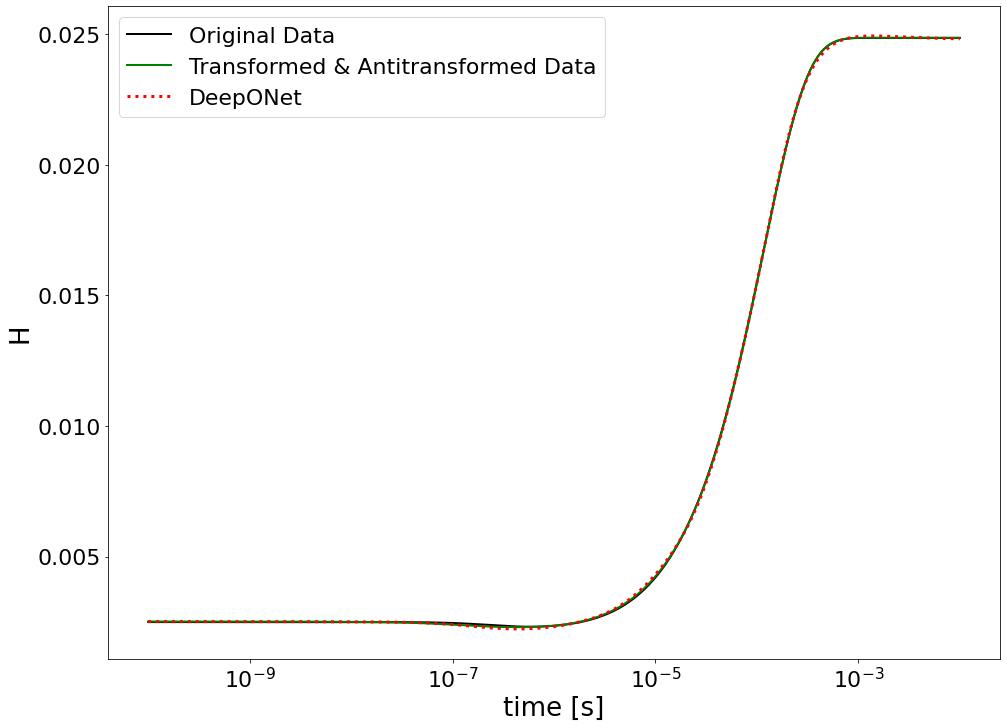

In [10]:
### Evaluating on Test Data

VarOI    = 'H'


FileName = DirDir + '/Orig/train/ext/y.csv.1'
Data     = pd.read_csv(FileName, header=0)
VarNames = list(Data.columns)
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break
VarNames.remove('t')
 

FileName   = DirDir + '/Orig/train/ext/CleanVars.csv'
Data       = pd.read_csv(FileName, header=0)
VarNamesPC = list(Data.columns)
for iVarPC in range(1,len(VarNames)):
    if (VarNames[iVarPC] == VarOI):
        print('iVar = ', iVarPC)
        break

        
FileName       = DirDir + '/Orig/train/ext/ResidenceTimes.csv'
Data           = pd.read_csv(FileName, header=None)
RestValVecTest = np.log10(Data.to_numpy())

iPC = 2


ax  = []

fig = plt.figure(figsize=(16,12))
ax.append(plt.axes())

fig = plt.figure(figsize=(16,12))
ax.append(plt.axes())
for iTest in CasesVec:
    RestVal                      = RestValVecTest[iTest]

    FileName                     = DirDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iTest+1)
    InputDataTest                = pd.read_csv(FileName, header=0)
    tVec                         = InputDataTest['t'].to_numpy()
    InputDataTest['log10(t)']    = np.log10(tVec)
    InputDataTest['log(t)']      = np.log(tVec)
    InputDataTest['log10(Rest)'] = RestVal * np.ones(len(tVec))
    yMatOrig_pca                 = InputDataTest[TestInputVars].to_numpy()
    y0_pca                       = yMatOrig_pca[0,:]
    print('RestVal = ', RestVal, '; y0_pca = ', y0_pca)
    
    FileName     = DirDir + '/Orig/train/ext/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMatOrig     = Data.to_numpy()[:,1:]
    
    yMattOrig    = (yMatOrig_pca.dot(A)) *D[:,0] + C[:,0]
    
    ax[0].plot(tVec, yMatOrig_pca[:,iPC], '-k',  label='Transformed Data', lw=2)
    ax[1].plot(tVec, yMatOrig[:,iVar],    '-k',  label='Original Data', lw=2)
    ax[1].plot(tVec, yMattOrig[:,iVar],   '-g',  label='Transformed & Antitransformed Data', lw=2)
    
    
    if (InputData.ProbApproach == 'Deterministic') or (NSamples == 1):
        
        yMat_pca = model.predict(InputDataTest[['log10(Rest)','t']])
        yMat_pre = (yMat_pca.dot(A))
        yMat     = yMat_pre*D[:,0] + C[:,0]
    
        ax[0].plot(tVec, yMat_pca[:,iPC], ':r', label='DeepONet', lw=3)
        ax[1].plot(tVec,  yMat[:,iVar], ':r', label='DeepONet', lw=3)
        
    else:
        
        ### Sampling NN
        yMat_pca_sum = np.zeros((yMatOrig_pca.shape[0], yMatOrig_pca.shape[1]))
        yMat_pca_sqr = np.zeros((yMatOrig_pca.shape[0], yMatOrig_pca.shape[1]))
        yMat_sum     = np.zeros((yMatOrig.shape[0], A.shape[1]))
        yMat_sqr     = np.zeros((yMatOrig.shape[0], A.shape[1]))

        for iSample in range(NSamples):
            yMat_pca = model.predict(InputDataTest[['log10(Rest)','t']])
            
            yMat_pca_sum += yMat_pca
            yMat_pca_sqr += yMat_pca**2
            
            yMat     = (yMat_pca.dot(A))*D[:,0] + C[:,0]
        
        
            yMat_sum += yMat
            yMat_sqr += yMat**2
            
        yMat_pca_mean = yMat_pca_sum/NSamples
        yMat_pca_std  = np.sqrt( yMat_pca_sqr/NSamples - yMat_pca_mean**2 )
        yMat_pca_p1   = yMat_pca_mean + 1.*yMat_pca_std
        yMat_pca_m1   = yMat_pca_mean - 1.*yMat_pca_std
        yMat_pca_p2   = yMat_pca_mean + 2.*yMat_pca_std
        yMat_pca_m2   = yMat_pca_mean - 2.*yMat_pca_std
        yMat_pca_p3   = yMat_pca_mean + 3.*yMat_pca_std
        yMat_pca_m3   = yMat_pca_mean - 3.*yMat_pca_std
            

        yMat_mean = yMat_sum/NSamples
        yMat_std  = np.sqrt( yMat_sqr/NSamples - yMat_mean**2 )
        yMat_p1   = yMat_mean + 1.*yMat_std
        yMat_m1   = yMat_mean - 1.*yMat_std
        yMat_p2   = yMat_mean + 2.*yMat_std
        yMat_m2   = yMat_mean - 2.*yMat_std
        yMat_p3   = yMat_mean + 3.*yMat_std
        yMat_m3   = yMat_mean - 3.*yMat_std
    
        ax[0].plot(tVec, yMat_pca_mean[:,iPC], 'b-', label=r'DeepONet, $\mu$')
        ax[0].plot(tVec, yMat_pca_p3[:,iPC],   'b:', label=r'DeepONet, $\mu+3\sigma$')
        ax[0].plot(tVec, yMat_pca_m3[:,iPC],   'b:', label=r'DeepONet, $\mu-3\sigma$')

        ax[1].plot(tVec, yMat_mean[:,iVar], 'b-', label=r'DeepONet, $\mu$')
        ax[1].plot(tVec, yMat_p3[:,iVar],   'b:', label=r'DeepONet, $\mu+3\sigma$')
        ax[1].plot(tVec, yMat_m3[:,iVarPC], 'b:', label=r'DeepONet, $\mu-3\sigma$')
    
    
ax[0].set_xscale('log')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel(r'$PC_'+str(iPC+1)+'$')
ax[0].legend()


ax[1].set_xscale('log')
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel(VarOI)
ax[1].legend()

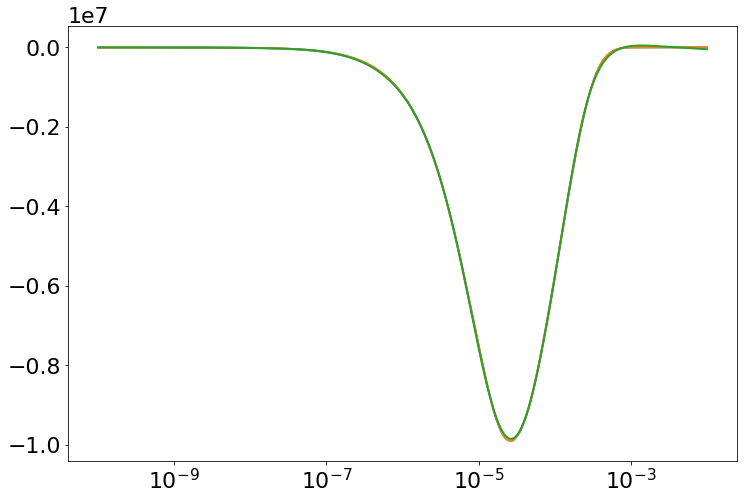

In [11]:
Var  = 'HH'

PSR  = rmnt.pinn.system.PSR(InputData)

FileName       = DirDir + '/Orig/train/ext/ySource.csv.' + str(iTest+1)
DataSource     = pd.read_csv(FileName, header=0)
VarNames_Orig  = list(DataSource.columns)
VarNames_Orig.remove('t')
iS_Orig        = VarNames_Orig.index(Var)
dy_dt_Orig     = DataSource[Var].to_numpy()/D[iS_Orig,0]


Rest = InputDataTest[['log10(Rest)']].to_numpy()
tVec = InputDataTest[['t']].to_numpy()
iS   = VarNames.index(Var)

dy_masked_dt_Orig = PSR.f(0., (yMattOrig-C[:,0])/D[:,0], Rest)
dy_masked_dt      = PSR.f(0., yMat_pre,  Rest)

fig = plt.figure(figsize=(12,8))
plt.plot(tVec, dy_dt_Orig)
plt.plot(tVec, dy_masked_dt_Orig[:,iS])
plt.plot(tVec, dy_masked_dt[:,iS])
plt.xscale('log')
# plt.xlim([1.e-14,1.e-13])
# plt.ylim([-1e9, 1e7])

Text(0, 0.5, '$d\\eta_{2}/dt$')

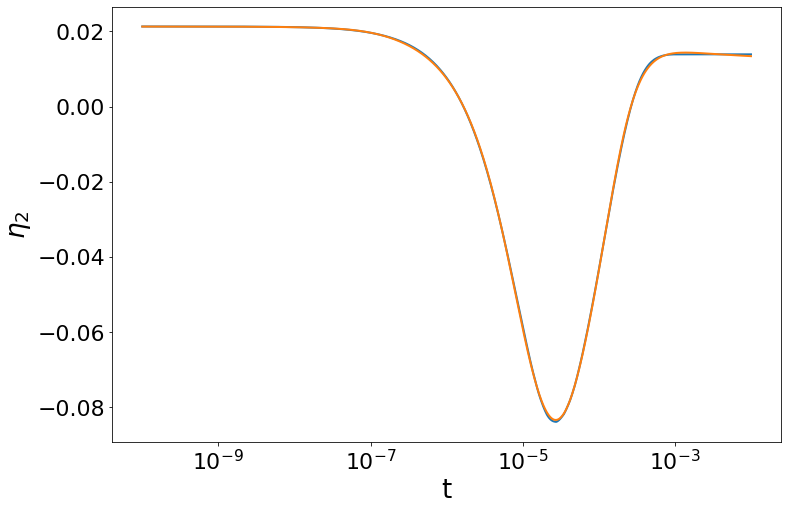

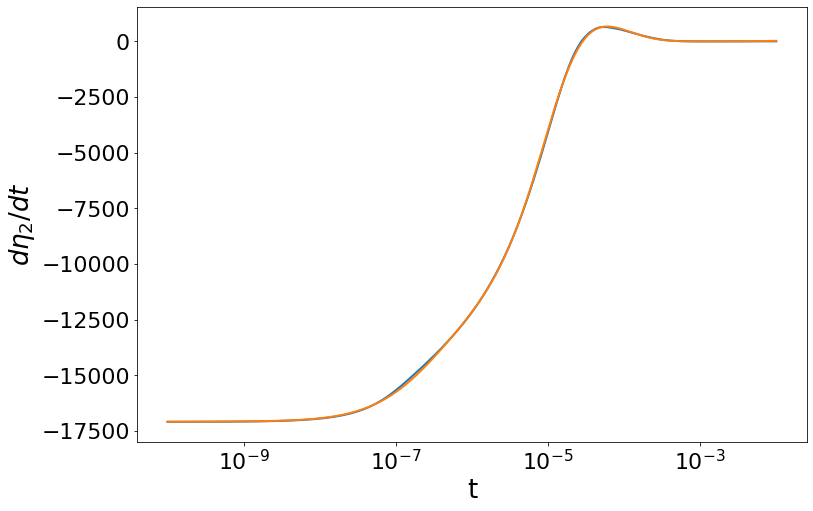

In [12]:
PSR  = rmnt.pinn.system.PSR(InputData)

Rest = InputDataTest[['log10(Rest)']].to_numpy()
tVec = InputDataTest[['t']].to_numpy()

iPC  = 1

tVecLog = np.log(tVec)[:,0]

#dy_masked_dt_Num  = np.gradient(yMat_pca[:,iPC], tVecLog) 
dy_masked_dt_Num  = np.gradient(yMat_pca[:,iPC], tVec[:,0]) 
dy_masked_dt_Orig = PSR.f_pc(0., yMatOrig_pca, Rest) #/ tVec#[:,0] 
dy_masked_dt      = PSR.f_pc(0., yMat_pca,     Rest) #/ tVec#[:,0]

fig = plt.figure(figsize=(12,8))
plt.plot(tVec, yMatOrig_pca[:,iPC], label='Integration')
plt.plot(tVec, yMat_pca[:,iPC],     label='DeepONet')
plt.xscale('log')
plt.xlabel('t')
plt.ylabel('$\eta_{'+str(iPC+1)+'}$')
# plt.xlim([1.e-3,1.e-2])
# plt.ylim([-1280, -1275])

fig = plt.figure(figsize=(12,8))
#plt.plot(tVec, dy_masked_dt_Num        )# /model.y_range[iPC])
plt.plot(tVec, dy_masked_dt_Orig[:,iPC])# /model.y_range[iPC])
plt.plot(tVec, dy_masked_dt[:,iPC]     )# /model.y_range[iPC])
plt.xscale('log')
plt.xlabel('t')
plt.ylabel('$d\eta_{'+str(iPC+1)+'}/dt$')
# plt.xlim([1.e-14,1.e-13])
# plt.ylim([-1e9, 1e7])

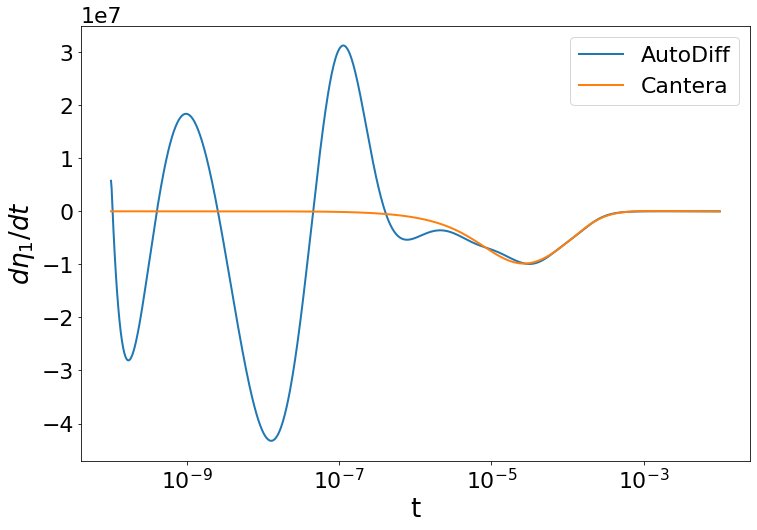

In [15]:
iPC = 0

dy_masked_dt_Num1  = np.gradient(yMat_pca[:,iPC], tVecLog) 
dy_masked_dt_Num2  = np.gradient(yMat_pca[:,iPC], tVec[:,0]) #* tVec[:,0]

fig = plt.figure(figsize=(12,8))
plt.plot(tVec, dy_masked_dt_Num2,   label='AutoDiff')
plt.plot(tVec, dy_masked_dt[:,iPC], label='Cantera')
plt.xscale('log')
#plt.ylim([-10,1])
plt.xlabel('t')
plt.ylabel('$d\eta_{'+str(iPC+1)+'}/dt$')
plt.legend()

In [16]:
Input   = {}
Weights = {}
for data_id in InputData.NTrain.keys():
    FileName         = InputData.PathToDataFld + '/train/'+data_id+'/Input.csv'
    Data             = pd.read_csv(FileName)
    Input[data_id]   = Data
    
    FileName         = InputData.PathToRunFld + '/Training/LossWeights/'+data_id+'_96.csv'
    Data             = pd.read_csv(FileName, header=None)
    Weights[data_id] = Data

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sventuri/WORKSPACE//ROMNet/PSR_10Cases/DeepONet/Deterministic/Run_3//Training/LossWeights/ics_96.csv'

In [ ]:
#%matplotlib qt

data_id = 'ics'

# fig = plt.figure()
# ax  = fig.add_subplot(projection='3d')
# ax.scatter(Input[data_id]['x'], Input[data_id]['v'], Weights[data_id][1])
# ax.set_xlabel('x')
# ax.set_ylabel('y')

fig = plt.figure()
plt.scatter(Input[data_id]['log10(Rest)'], Weights[data_id][0])
plt.xlabel('t')

In [ ]:
#%matplotlib qt

data_id = 'res'

# fig = plt.figure()
# ax  = fig.add_subplot(projection='3d')
# ax.scatter(Input[data_id]['t'], Input[data_id]['x'], Weights[data_id][1])
# ax.set_xlabel('t')
# ax.set_ylabel('x')

fig = plt.figure()
plt.scatter(Input[data_id]['t'], Weights[data_id][0])
plt.xlabel('t')
plt.xscale('log')
plt.yscale('log')


# fig = plt.figure()
# plt.scatter(Input[data_id]['t'], Weights[data_id][1])
# plt.xlabel('t')

In [ ]:
Data = pd.read_csv('/Users/sventuri/Desktop/Input.csv', header=None).to_numpy()
plt.plot(Data[:,0], Data[:,3], 'o')

plt.plot(tVec, yMat_pca[:,2])

plt.xscale('log')

In [ ]:
Data = pd.read_csv('/Users/sventuri/Desktop/DAJE/Output.csv', header=None).to_numpy()

iPC  = 1

# plt.plot(Data[:,0], Data[:,3], 'o', markersize=2)
# plt.plot(Data[:,0], Data[:,6], 'o', markersize=2)

# plt.plot(Data[-1001000:-1000000,0], Data[-1001000:-1000000,iPC], 'k+', markersize=2)
# plt.plot(Data[-101000:-100000,0], Data[-1001000:-1000000,iPC+3], 'ro', markersize=2)

plt.plot(Data[-1000:-1,0], Data[-1000:-1,iPC],   'b+', markersize=2)
plt.plot(Data[-1000:-1,0], Data[-1000:-1,iPC+3], 'go', markersize=2)

plt.xscale('log')
#plt.plot(tVecLog, dy_masked_dt[:,0]/model.y_range[0])
#plt.plot(tVecLog, dy_masked_dt_Num/model.y_range[iPC])
# plt.xlim([-5, -4])
# plt.ylim([-1, -0.9])